# Iterative Training of DeepTDA CVs on 2D Model Potential
This notebook illustrates the training of DeepTDA CVs on a mix of unbiased data and trajectory data generated by Metadynamics of Paths. 
To successfully run this notebook, create a conda environment from the provided mlcvs_pt1.4.yml file or load the required packages manually:
- numpy
- pandas
- matplotlib
- tqdm
- pytorch=1.8 (version needs to match the LibTorch version used in PLUMED to load the scripted models)
- mlcolvar package from [https://github.com/luigibonati/mlcolvar], v0.2.0 (mlcvs)

In [23]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import os
import mlcvs    # new version: mlcolvar
from sklearn.cluster import OPTICS
from utils import V_mb, plot_isolines_CV, plot_isolines_MuBr, plot_paths, plot_opes, calc_average_distance, calc_path_lengths, convert_colvar, read_paths
from mlcvs.utils import load_dataframe, FastTensorDataLoader
from mlcvs.tda import DeepTDA_CV

# seed numpy and pytorch RNGs
seed = 1111
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

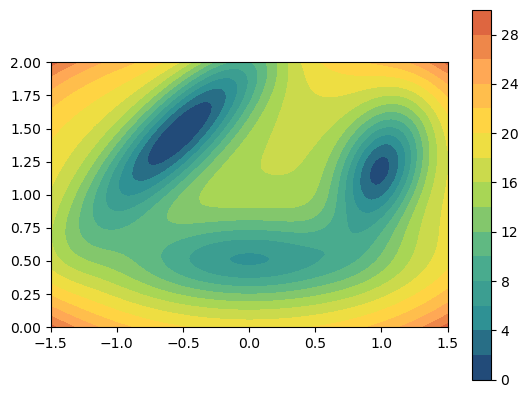

In [3]:
# Visualize 2D potential

%matplotlib inline
nx, ny = (100, 100)
xlims=(-1.5, 1.5)#(-1.8, 1.2)
ylims=(-0., 2.)#(-0.4, 2.1)
x = np.linspace(xlims[0],xlims[1], nx)
y = np.linspace(ylims[0],ylims[1], ny)
xv, yv = np.meshgrid(x, y)

pot = V_mb(xv,yv)
max_pot = 35
pot[pot>max_pot] = np.NaN

fig,ax = plt.subplots(dpi=100)
pp = ax.contourf(xv,yv,pot,15,cmap='fessa') 
# ax.contour(xv,yv,pot,15)
ax.set_aspect('equal')
plt.colorbar(pp,ax=ax)

## 2-state DeepTDA CV

In [4]:
# unbiased training data in basins A and C
folder = '../2D_model_potential/data/'
colvarA = load_dataframe(folder+'mubr_colvar_A')
colvarA['label'] = np.full(len(colvarA), 0)
colvarC = load_dataframe(folder+'mubr_colvar_C')
colvarC['label'] = np.full(len(colvarC), 1)
colvar_ub = pd.concat([colvarA, colvarC], ignore_index=True)
fig,ax = plt.subplots()
colvar_ub.plot.scatter('p.x','p.y', c='label', cmap='fessa', ax=ax)
plot_isolines_MuBr(ax)

### Train the 2-state DeepTDA CV

In [24]:
# shuffle and prepare training/valivation data
sample_colvar = colvar_ub.sample(frac=1)

X = torch.Tensor(sample_colvar.filter(regex='p.x|p.y').values)
y = torch.Tensor(sample_colvar['label'].values)

# split the data into training/validation data
ntrain = int(0.8*len(X))

train_data = [X[:ntrain], y[:ntrain]]
valid_data = [X[ntrain:], y[ntrain:]]

train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

n_features = X.shape[1]

# - network parameters - 
layers = [2, 24, 12]    # model architecture
n_states = 2            # number of states
n_cv = 1                # number of CVs to train (i.e. dimension of last hidden layer / latent space)
# - target distribution values -
mu_tg = [-7., 7.]       # centers of peaks in the target distribution
sig_tg = [0.2, 0.2]     # widths of peaks in the target distribution

# define and train model
model_1 = DeepTDA_CV(layers, n_states, n_cv, mu_tg, sig_tg)
opt = torch.optim.Adam(model_1.parameters(), lr=0.001, weight_decay=1e-5)
model_1.set_optimizer(opt)
model_1.set_earlystopping(patience=15)
model_1.fit(train_loader, valid_loader, log_every=10, nepochs=3000)
# model_1.export(folder, traced_name='model_2Dpot_2stateTDA.ptc')

epoch           loss_train      loss_valid      
10              116.471         116.482         
20              114.395         114.396         
30              112.375         112.372         
40              110.206         110.208         
50              107.872         107.873         
60              105.262         105.260         
70              102.339         102.331         
80              99.041          99.033          
90              95.318          95.312          
100             91.258          91.251          
110             86.861          86.850          
120             82.133          82.120          
130             77.096          77.079          
140             71.800          71.773          
150             66.291          66.255          
160             60.615          60.574          
170             54.842          54.801          
180             49.037          48.993          
190             43.270          43.223          
200             37.6

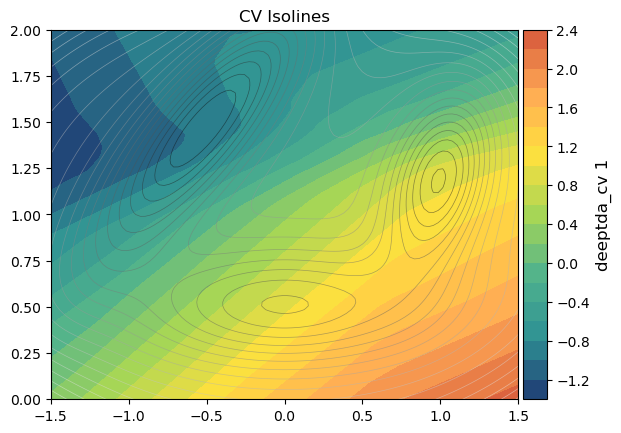

In [25]:
_, ax = plt.subplots()
ax.set_title('CV Isolines')
plot_isolines_MuBr(ax, xlims, ylims)
plot_isolines_CV(model_1, limits=(xlims,ylims), num_points=100, levels=20, axs=[ax])

### Standard OPES Simulation using 2-state CV

In [7]:
# plot simulation results
colvar_op1 = load_dataframe(folder+"mubr_colvar_2stateTDA")
plot_opes(colvar_op1, cvname='deep.node-0', title='initial deepTDA CV in OPES simulation')

(<Figure size 1000x700 with 8 Axes>,
 array([<Axes: xlabel='time', ylabel='p.x'>,
        <Axes: xlabel='time', ylabel='p.y'>,
        <Axes: xlabel='time', ylabel='opes.bias'>,
        <Axes: xlabel='p.x', ylabel='p.y'>], dtype=object))

### MoP Simulation using 2-state CV

In [8]:
# load/convert path data
folder = '../2D_model_potential/data/'
mdop_path = ''
ppath = folder+'paths_2Dpot_mop_2stateTDA/'
convert = False    # convert from MoP colvars or read paths
skip = 0           # number of paths to skip

if convert:
    path_data_1 = convert_colvar(mdop_path, ppath)
else:
    files = sorted(os.listdir(ppath), key = lambda x: int(x.split('.')[-1]))[skip:]
    path_data_1 = read_paths(ppath, files)

Reading paths...


100%|██████████| 3000/3000 [00:02<00:00, 1400.69it/s]


/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, 

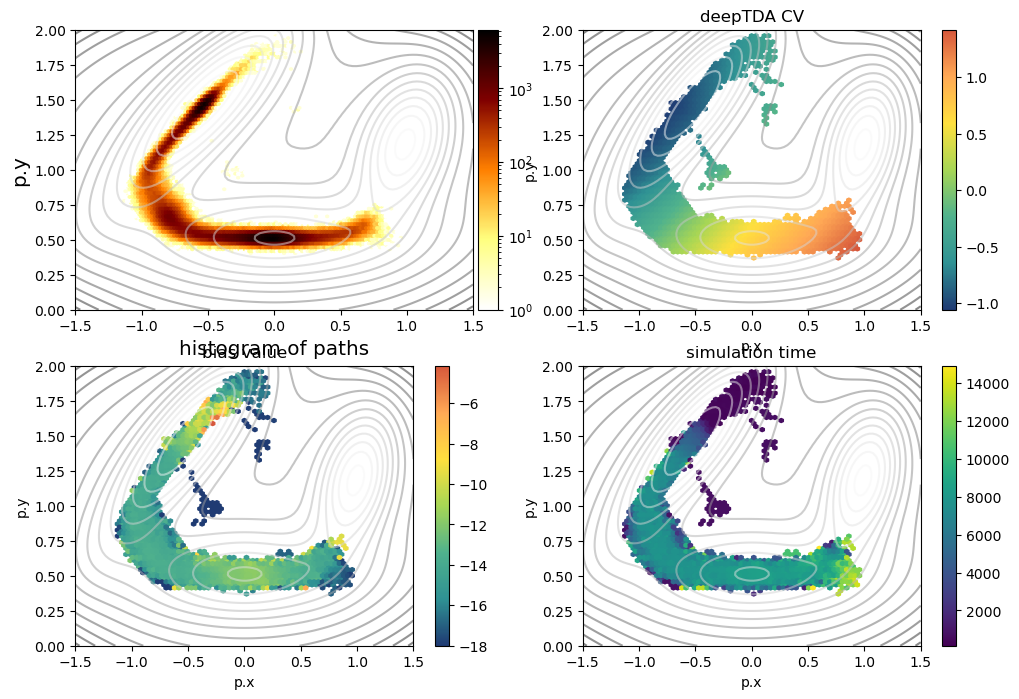

In [9]:
# plot MoP results
%matplotlib inline

# plot hexbin hist
as_hist = True
lx = 'p.x'
ly = 'p.y'
cvname = 'deep.node-0'
n_beads = len(path_data_1[path_data_1['path_id'] == path_data_1['path_id'][0]])
n_paths = len(path_data_1['path_id'].unique())

fig, axs = plt.subplots(2, 2, figsize=(12,8), dpi=100)
axs = axs.flatten()
plot_paths(path_data_1, lx, ly, 'histogram of paths', ax=axs[0], cmap='afmhot_r', bins='log')

# DeepTDA CV evaluated on trajectory conformations
path_data_1.plot.hexbin(lx, ly, C=cvname, gridsize=80, extent=(*xlims, *ylims), cmap='fessa', ax=axs[1])
axs[1].set_title('deepTDA CV')

# OPES bias value for the trajectories
path_data_1.plot.hexbin(lx, ly, C='opes.bias', gridsize=80, extent=(*xlims, *ylims), cmap='fessa', ax=axs[2])
axs[2].set_title('bias value')

# simulation time (in trajectory space)
path_data_1.plot.hexbin(lx, ly, C='time', gridsize=80, extent=(*xlims, *ylims), cmap='viridis', ax=axs[3])
axs[3].set_title('simulation time')

axs[0].contour(xv,yv,pot,15, cmap='Greys', alpha=.5)
axs[1].contour(xv,yv,pot,15, cmap='Greys', alpha=.5)
axs[2].contour(xv,yv,pot,15, cmap='Greys', alpha=.5)
axs[3].contour(xv,yv,pot,15, cmap='Greys', alpha=.5)

# of filtered paths: 0.0


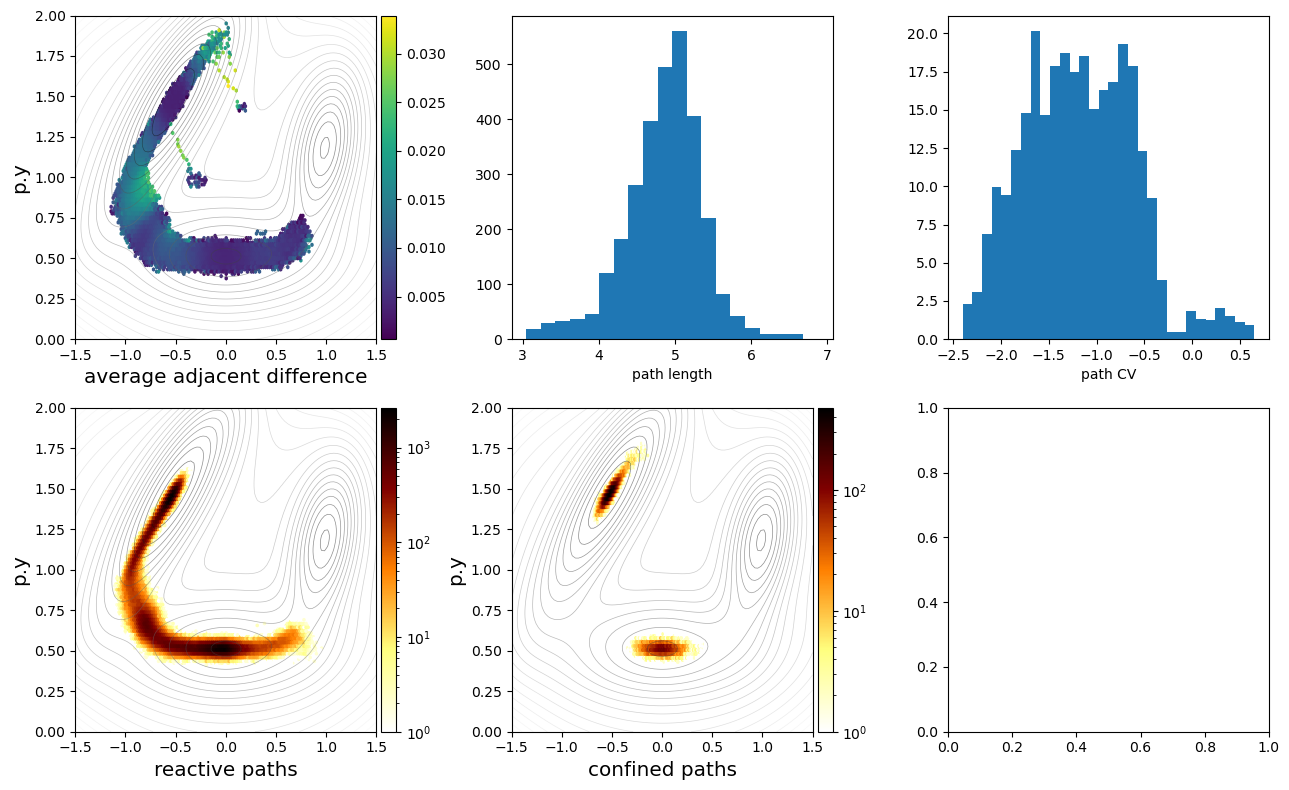

In [10]:
# analysing MoP paths
fig, axs = plt.subplots(2, 3, figsize=(13, 8), dpi=100)
axs = axs.flatten()

# calculate average bead displacement
avg_diff = calc_average_distance(path_data_1, labels=[lx,ly], kernel_size=15)
plot_paths(avg_diff, lx, ly, 'average adjacent difference', C='dist', ax=axs[0])
plot_isolines_MuBr(axs[0], xlims, ylims)

# calculate path lengths (w.r.t DeepTDA CV value) 
path_lens = calc_path_lengths(path_data_1, labels=[cvname])
# add path length to dataframe
for i, l in path_lens:
    path_data_1.loc[path_data_1['path_id'] == i, 'path_length'] = l
axs[1].hist(path_lens[:,1], bins=20)
axs[1].set_xlabel('path length')

# histogram of trajectory CV values (CV_t, e-t-e distance)
axs[2].hist(path_data_1['CV'], bins=30, weights=np.full(len(path_data_1['CV']), 1./n_paths))
axs[2].set_xlabel('path CV')

# identify reactive paths
reactive = path_data_1[path_data_1['CV'].abs() >= 1.]
plot_paths(reactive, lx, ly, 'reactive paths', ax=axs[3], bins='log', cmap='afmhot_r')
plot_isolines_MuBr(axs[3], xlims,ylims)

# identify trapped/confined paths
confined = path_data_1[path_data_1['CV'].abs() <= 0.4]
plot_paths(confined, lx, ly, 'confined paths', ax=axs[4], bins='log', cmap='afmhot_r')
plot_isolines_MuBr(axs[4], xlims,ylims)

# filter paths by length/completeness/bias
filter_ids = []
for _, df in path_data_1.groupby('path_id'):
    if np.any((df['p.x'] >= 0.8) & (df['p.y'] >= 1.1)) & np.any((df['p.x'] <= -0.2) & (df['p.y'] >= 1.2)):
        filter_ids.append(df['path_id'].iloc[0])
filter_ids = np.unique(filter_ids)
filter_paths = path_data_1[path_data_1['path_id'].isin(filter_ids)]

# filter_paths = path_data_1[path_data_1['path_length'].between(16.,25.)]
# filter_paths = path_data_1[path_data_1['CV'].abs() >= 1.7]
# filter_paths = path_data_1[path_data_1['opes.bias'] >= -0.7]

for _,p in filter_paths.groupby('path_id'):
    axs[5].plot(p[lx], p[ly])
# plot_paths(filter_paths, lx, ly, 'filtered paths', ax=axs[5], bins='log', cmap='afmhot_r')
print('# of filtered paths:', len(filter_paths)/n_beads)

plt.tight_layout()

## 4-state DeepTDA CV

### Train 3-state CV

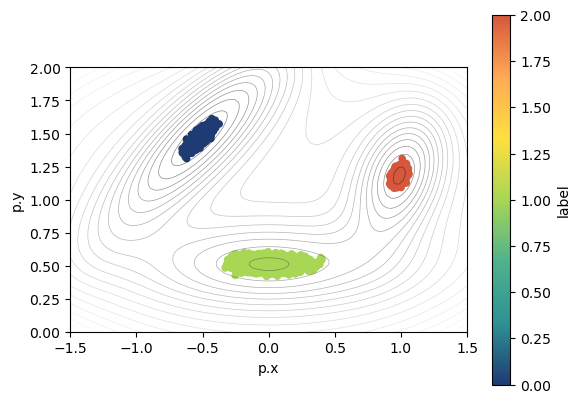

In [11]:
# select training data for 3-state CV
from sklearn.cluster import OPTICS

# unbiased
folder = '../2D_model_potential/data/'
colvarA = load_dataframe(folder+'mubr_colvar_A')
colvarA['label'] = np.full(len(colvarA), 0)
colvarC = load_dataframe(folder+'mubr_colvar_C')
colvarC['label'] = np.full(len(colvarC), 2)

# from confined paths
# cluster to automatically differentiate "new" configurations in confined paths from known states
selection = pd.concat([colvarA, confined, colvarC], ignore_index=True)
X_sel = selection.filter(regex='p.x|p.y').values
cluster = OPTICS(min_samples=50, max_eps=10.).fit(X_sel)

# upon inspection, add newly found state as additional intermediate to dataset
colvarB = selection[cluster.labels_ == 1].sample(len(colvarA))
colvarB['label'] = np.full(len(colvarB), 1)
colvar = pd.concat([colvarA, colvarB, colvarC], ignore_index=True)

fig, ax = plt.subplots()
colvar.plot.scatter('p.x', 'p.y', c='label', ax=ax, cmap='fessa')
plot_isolines_MuBr(ax, xlims, ylims)
ax.set_aspect('equal')

In [26]:
# train 3-state deepTDA
# shuffle and prepare training/validation data
sample_colvar = colvar.sample(frac=1)

X = torch.Tensor(sample_colvar.filter(regex='p.x|p.y').values)
y = torch.Tensor(sample_colvar['label'].values)

# split data into training/validation data
ntrain = int(0.8*len(X))

train_data = [X[:ntrain], y[:ntrain]]
valid_data = [X[ntrain:], y[ntrain:]]

train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

n_features = X.shape[1]

# - model parameters - 
layers = [2, 24, 12]        # model architecture
n_states = 3                # number of states
n_cv = 1                    # number of CVs to train (i.e. dimension of last hidden layer / latent space)
# - target distribution values -
mu_tg = [-15, 0, 15]        # centers of peaks in the target distribution
sig_tg = [0.3, 1., 0.3]     # widths of peaks in the target distribution

# train model
model_2 = DeepTDA_CV(layers, n_states, n_cv, mu_tg, sig_tg, activation='relu')
opt = torch.optim.Adam(model_2.parameters(), lr=0.001, weight_decay=1e-5)
model_2.set_optimizer(opt)
model_2.set_earlystopping(patience=20)
model_2.fit(train_loader, valid_loader, log_every=10, nepochs=5000, standardize_inputs=True, standardize_outputs=True)
# model_2.export(folder, traced_name='model_2Dpot_3stateTDA.ptc')


epoch           loss_train      loss_valid      
10              732.528         732.476         
20              724.672         724.582         
30              716.001         715.869         
40              706.824         706.635         
50              695.956         695.658         
60              678.659         678.117         
70              659.750         659.172         
80              637.017         636.395         
90              611.343         610.612         
100             582.776         581.929         
110             552.339         551.385         
120             519.652         518.618         
130             485.128         484.093         
140             449.374         448.329         
150             413.084         412.038         
160             377.014         376.015         
170             341.735         340.773         
180             307.703         306.814         
190             276.714         275.951         
200             249.

In [27]:
# evaluate
_, ax = plt.subplots(1, 2, figsize=(12,5), dpi=100)
ax[0].set_title('CV Isolines')
plot_isolines_MuBr(ax[0], xlims, ylims)
plot_isolines_CV(model_2, limits=(xlims,ylims), num_points=100, levels=20, axs=[ax[0]])

with torch.no_grad():
    outA = model_2(torch.Tensor(colvarA.filter(regex='p.x|p.y').values)).numpy()
    outB = model_2(torch.Tensor(colvarB.filter(regex='p.x|p.y').values)).numpy()
    outC = model_2(torch.Tensor(colvarC.filter(regex='p.x|p.y').values)).numpy()
bins = np.linspace(-1.2, 1.2, 44)
ax[1].hist(outA, bins=bins, alpha=0.7)
ax[1].hist(outB, bins=bins, alpha=0.7)
ax[1].hist(outC, bins=bins, alpha=0.7)

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.770e+03, 4.848e+03, 4.700e+01, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([-1.2       , -1.14418605, -1.08837209, -1.03255814, -0.97674419,
        -0.92093023, -0.86511628, -0.80930233, -0.75348837, -0.69767442,
        -0.64186047, -0.58604651, -0.53023256, -0.4744186 , -0.41860465,
        -0.3627907 , -0.30697674, -0.25116279, -0.19534884, -0.13953488,
        -0.08372093, -0.02790698,  0.02790698,  0.08372093,  0.13953488,
         0.19534884,  0.25116279,  0.30697674,  0.3627907 ,  0.41860465,
         0.4744186 ,  0

In [28]:
# reevaluate new CV on MoP data to allow for more accurate classification
tdacv = model_2(torch.Tensor(path_data_1.filter(regex='p.x|p.y').values)).detach().numpy()[:,0]
path_reval = path_data_1
path_reval['deep.node-0'] = tdacv
# apply to individual trajectories to calculate trajectory CV (end-to-end distance)
def apply_trajcv(pgrp):
    val = pgrp['deep.node-0'].iloc[-1] - pgrp['deep.node-0'].iloc[0]
    pgrp['CV'] = np.full(len(pgrp), val)
    return pgrp
path_reval = path_reval.groupby('path_id').apply(apply_trajcv).reset_index(level=0, drop=True)

# of filtered paths: 0.0


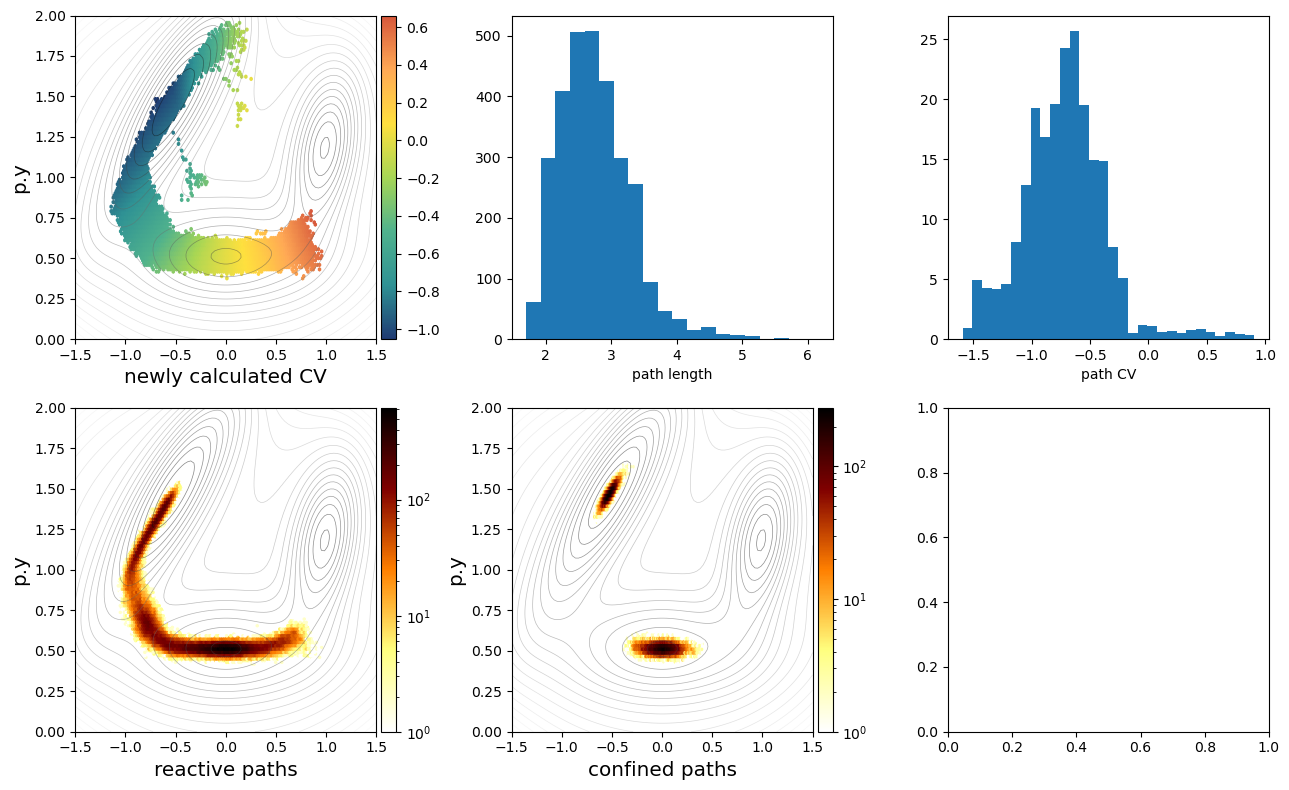

In [30]:
# analyse reevaluated paths
fig, axs = plt.subplots(2, 3, figsize=(13, 8), dpi=100)
axs = axs.flatten()

plot_paths(path_reval, lx, ly, 'newly calculated CV', C='deep.node-0', ax=axs[0], cmap='fessa')
plot_isolines_MuBr(axs[0], xlims, ylims)

# calculate path lengths (w.r.t. DeepTDA CV value)
path_lens = calc_path_lengths(path_reval, labels=['deep.node-0'])
# add path length to dataframe
for i, l in path_lens:
    path_reval.loc[path_reval['path_id'] == i, 'path_length'] = l
axs[1].hist(path_lens[:,1], bins=20)
axs[1].set_xlabel('path length')

# histogram of trajectory CV (CV_t) values 
axs[2].hist(path_reval['CV'], bins=30, weights=np.full(len(path_reval['CV']), 1./n_paths))
axs[2].set_xlabel('path CV')

# identify reactive paths
reactive = path_reval[path_reval['CV'].abs() >= 1.]
plot_paths(reactive, lx, ly, 'reactive paths', ax=axs[3], bins='log', cmap='afmhot_r')
plot_isolines_MuBr(axs[3], xlims,ylims)

# identify trapped/confined paths
confined = path_reval[path_reval['CV'].abs() <= 0.3]
plot_paths(confined, lx, ly, 'confined paths', ax=axs[4], bins='log', cmap='afmhot_r')
plot_isolines_MuBr(axs[4], xlims,ylims)

# filter paths by length/completeness/bias
filter_ids = []
for _, df in path_reval.groupby('path_id'):
    if np.any((df['p.x'] >= 0.8) & (df['p.y'] >= 1.1)) & np.any((df['p.x'] <= -0.2) & (df['p.y'] >= 1.2)):
        filter_ids.append(df['path_id'].iloc[0])
filter_ids = np.unique(filter_ids)
filter_paths = path_reval[path_reval['path_id'].isin(filter_ids)]

# filter_paths = path_data_1[path_data_1['CV'].abs() >= 1.7]
# filter_paths = path_data_1[path_data_1['opes.bias'] >= -0.7]

for _,p in filter_paths.groupby('path_id'):
    axs[5].plot(p[lx], p[ly])
# plot_paths(filter_paths, lx, ly, 'filtered paths', ax=axs[5], bins='log', cmap='afmhot_r')
print('# of filtered paths:', len(filter_paths)/n_beads)

plt.tight_layout()

### Train 4-state CV

6667
53820
6667
6667


Text(0.5, 0, 'x [a.u.]')

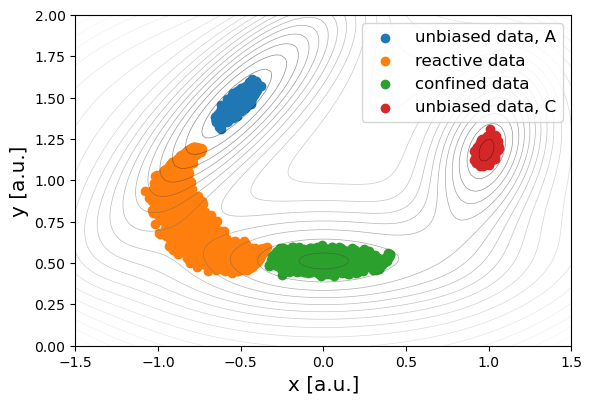

In [31]:
# select data from reactive paths & add to dataset
# calculate mean/std of the state distributions in CV space
with torch.no_grad():
    outA = model_2(torch.Tensor(colvarA.filter(regex='p.x|p.y').values)).numpy()
    outB = model_2(torch.Tensor(colvarB.filter(regex='p.x|p.y').values)).numpy()
    outC = model_2(torch.Tensor(colvarC.filter(regex='p.x|p.y').values)).numpy()

mA = outA.mean()
sA = outA.std()
mB = outB.mean()
sB = outB.std()
mC = outC.mean()
sC = outC.std()

# select data
f = 3
colvarB1 = reactive[reactive['deep.node-0'].between(mA+1*sA, mB-4*sB)]
colvarB1 = colvarB1[colvarB1['p.y'] < 1.2]
colvarB1['label'] = np.full(len(colvarB1), 1)
colvarB['label'] = np.full(len(colvarB), 2)
colvarC['label'] = np.full(len(colvarC), 3)
print(len(colvarA))
print(len(colvarB1))
print(len(colvarB))
print(len(colvarC))

# ensure equal number of data points
colvarB1 = colvarB1.sample(min(len(colvarB1), len(colvarA)))
colvarB = colvarB.sample(len(colvarA))
colvar_2 = pd.concat([colvarA, colvarB1, colvarB, colvarC], ignore_index=True)

# plot training data
_,ax = plt.subplots()
ax.scatter('p.x', 'p.y', label='unbiased data, A', data=colvarA)
ax.scatter('p.x', 'p.y', label='reactive data', data=colvarB1)
ax.scatter('p.x', 'p.y', label='confined data', data=colvarB)
ax.scatter('p.x', 'p.y', label='unbiased data, C', data=colvarC)
plot_isolines_MuBr(ax,xlims,ylims)
ax.set_aspect('equal')
ax.legend(fontsize='large')
ax.set_ylabel('y [a.u.]', fontsize='x-large')
ax.set_xlabel('x [a.u.]', fontsize='x-large')


In [34]:
# train 4-state deepTDA CV on unbiased data + trapped + confined
# shuffle and prepare training/validation data
sample_colvar = colvar_2.sample(frac=1)

X = torch.Tensor(sample_colvar.filter(regex='p.x|p.y').values)
y = torch.Tensor(sample_colvar['label'].values)

ntrain = int(0.8*len(X))

train_data = [X[:ntrain], y[:ntrain]]
valid_data = [X[ntrain:], y[ntrain:]]

train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

n_features = X.shape[1]

# model parameters
layers = [2, 24, 12]
n_states = 4 
n_cv = 1
# target distribution parameters
mu_tg = [-30, -15, -0, 30]
sig_tg = [0.3, 4., 1., 0.3]

model_3 = DeepTDA_CV(layers, n_states, n_cv, mu_tg, sig_tg)
opt = torch.optim.Adam(model_3.parameters(), lr=0.001, weight_decay=1e-5)
model_3.set_optimizer(opt)
model_3.set_earlystopping(patience=15)
model_3.fit(train_loader, valid_loader, log_every=100, nepochs=5000)
model_3.export('', traced_name='model_2Dpot_4stateTDA.ptc')

epoch           loss_train      loss_valid      
100             4977.941        4963.365        
200             1865.551        1844.416        
300             1071.937        1070.688        
400             738.743         738.842         
500             457.646         457.794         
600             262.063         261.785         
700             125.860         124.796         
800             45.873          45.041          
900             21.080          20.779          
1000            13.709          13.730          
1100            10.364          10.641          
1200            8.147           8.616           
1300            6.467           7.084           
1400            5.177           5.880           
1500            4.193           4.951           
1600            3.479           4.258           
1700            2.936           3.725           
1800            2.516           3.315           
1900            2.165           2.973           
2000            1.86

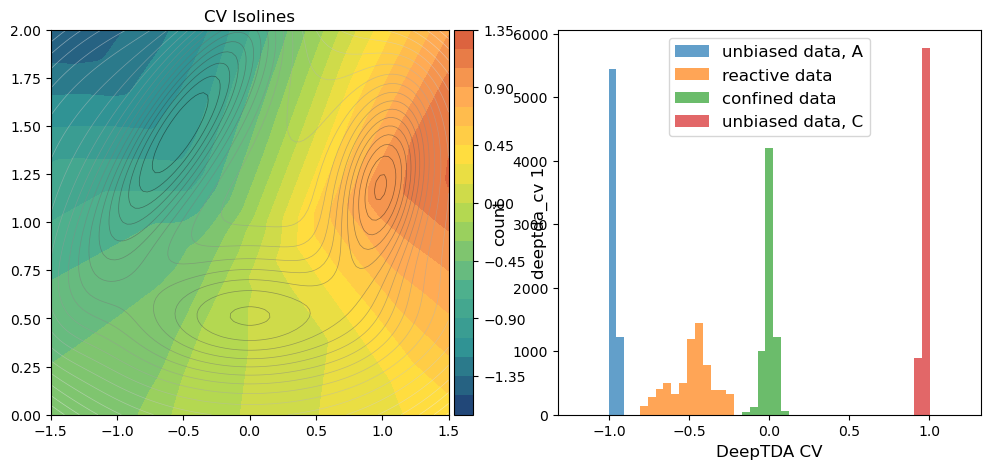

In [35]:
# model_3 = torch.jit.load('paper/mubr/final/model_tdaAC+2i_2.ptc')

_, ax = plt.subplots(1, 2, figsize=(12,5), dpi=100)
ax[0].set_title('CV Isolines')
plot_isolines_MuBr(ax[0], xlims, ylims)
plot_isolines_CV(model_3, limits=(xlims,ylims), num_points=100, levels=20, axs=[ax[0]])

with torch.no_grad():
    outA = model_3(torch.Tensor(colvarA.filter(regex='p.x|p.y').values)).numpy()
    outB1 = model_3(torch.Tensor(colvarB1.filter(regex='p.x|p.y').values)).numpy()
    outB = model_3(torch.Tensor(colvarB.filter(regex='p.x|p.y').values)).numpy()
    # outB2 = model_3(torch.Tensor(colvarB2.filter(regex='p.x|p.y').values)).numpy()
    outC = model_3(torch.Tensor(colvarC.filter(regex='p.x|p.y').values)).numpy()
bins = np.linspace(-1.2, 1.2, 50)
ax[1].hist(outA, bins=bins, alpha=0.7, label='unbiased data, A')
ax[1].hist(outB1, bins=bins, alpha=0.7, label='reactive data')
ax[1].hist(outB, bins=bins, alpha=0.7, label='confined data')
# [1]1].hist(outB2, bins=bins, alpha=0.7)
ax[1].hist(outC, bins=bins, alpha=0.7, label='unbiased data, C')
ax[1].set_xlabel('DeepTDA CV', fontsize='large')
ax[1].set_ylabel('count', fontsize='large')
ax[1].legend(fontsize='large')

### Standard OPES simulation using 4-state DeepTDA CV

In [19]:
colvar_op2 = load_dataframe(folder+"mubr_colvar_4stateTDA")
plot_opes(colvar_op2, title='4-state DeepTDA CV in OPES simulation')

(<Figure size 1000x700 with 8 Axes>,
 array([<Axes: xlabel='time', ylabel='p.x'>,
        <Axes: xlabel='time', ylabel='p.y'>,
        <Axes: xlabel='time', ylabel='opes.bias'>,
        <Axes: xlabel='p.x', ylabel='p.y'>], dtype=object))

### MoP simulation using 4-state DeepTDA CV

In [20]:
# load/convert path data
folder = '../2D_model_potential/data/'
mdop_path = ''
ppath = folder+'paths_2Dpot_mop_4stateTDA/'
convert = False    # convert from MoP colvars or read paths
skip = 0           # number of paths to skip

if convert:
    path_data_2 = convert_colvar(mdop_path, ppath)
else:
    files = sorted(os.listdir(ppath), key = lambda x: int(x.split('.')[-1]))[skip:]
    path_data_2 = read_paths(ppath, files)

Reading paths...


  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1469.36it/s]


/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/lukasmuellender/miniconda3/envs/mlcvs_pt1.13/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, 

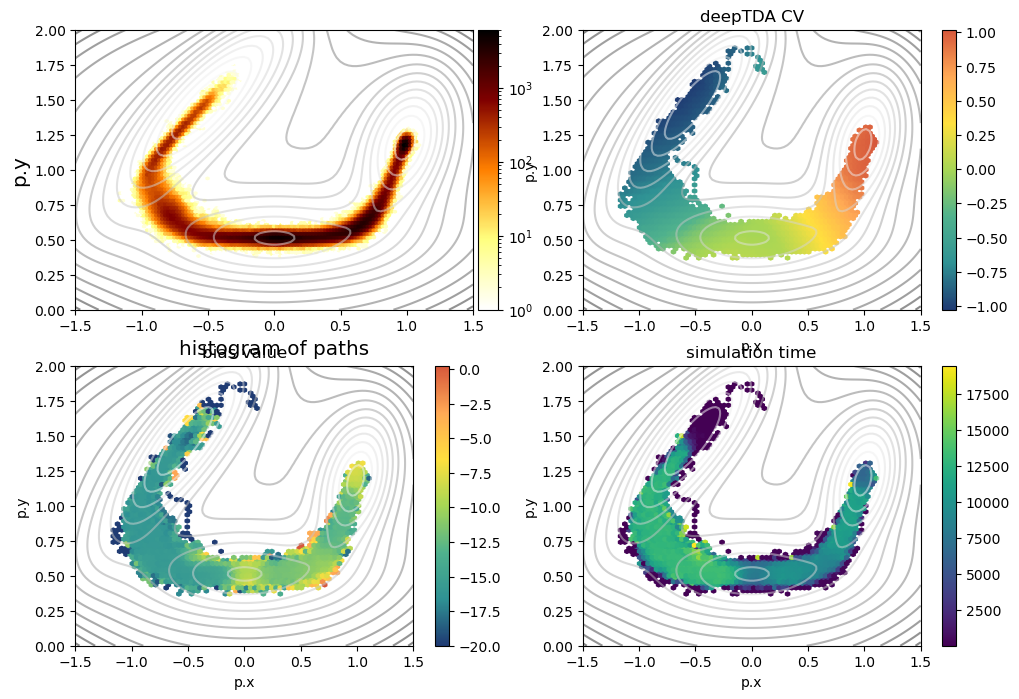

In [21]:
# plot hexbin hist
as_hist = True
lx = 'p.x'
ly = 'p.y'
cvname = 'deep.node-0'
n_beads = len(path_data_2[path_data_2['path_id'] == path_data_2['path_id'][0]])
n_paths = len(path_data_2['path_id'].unique())

fig, axs = plt.subplots(2, 2, figsize=(12,8), dpi=100)
axs = axs.flatten()
plot_paths(path_data_2, lx, ly, 'histogram of paths', ax=axs[0], cmap='afmhot_r', bins='log')

# DeepTDA CV evaluated on trajectory conformations 
path_data_2.plot.hexbin(lx, ly, C=cvname, gridsize=80, extent=(*xlims, *ylims), cmap='fessa', ax=axs[1])
axs[1].set_title('deepTDA CV')

# OPES bias value for the trajectories
path_data_2.plot.hexbin(lx, ly, C='opes.bias', gridsize=80, extent=(*xlims, *ylims), cmap='fessa', ax=axs[2])
axs[2].set_title('bias value')

# simulation time (in trajectory space)
path_data_2.plot.hexbin(lx, ly, C='time', gridsize=80, extent=(*xlims, *ylims), cmap='viridis', ax=axs[3])
axs[3].set_title('simulation time')

axs[0].contour(xv,yv,pot,15, cmap='Greys', alpha=.5)
axs[1].contour(xv,yv,pot,15, cmap='Greys', alpha=.5)
axs[2].contour(xv,yv,pot,15, cmap='Greys', alpha=.5)
axs[3].contour(xv,yv,pot,15, cmap='Greys', alpha=.5)

In [22]:
# analysing paths
fig, axs = plt.subplots(2, 3, figsize=(13, 8), dpi=100)
axs = axs.flatten()

# calculate average bead displacement
avg_diff = calc_average_distance(path_data_2, labels=[lx,ly], kernel_size=15)
plot_paths(avg_diff, lx, ly, 'average adjacent difference', C='dist', ax=axs[0])
plot_isolines_MuBr(axs[0], xlims, ylims)

# calculate path lengths (w.r.t. DeepTDA CV value)
path_lens = calc_path_lengths(path_data_2, labels=['deep.node-0'])
# add path length to dataframe
for i, l in path_lens:
    path_data_2.loc[path_data_2['path_id'] == i, 'path_length'] = l
axs[1].hist(path_lens[:,1], bins=30)
axs[1].set_xlabel('path length')

# histogram of trajectory CV (CV_t) values 
axs[2].hist(path_data_2['deep.node-0'], bins=30, density=True)
axs[2].set_xlabel('DeepTDA CV')

# identify reactive trajectories
reactive_2 = path_data_2[path_data_2['CV'].abs() >= 1.5]
plot_paths(reactive_2, lx, ly, 'reactive paths', ax=axs[3], bins='log', cmap='afmhot_r')
plot_isolines_MuBr(axs[3], xlims,ylims)

# identify trapped/confined trajectories
confined_2 = path_data_2[path_data_2['CV'].abs() <= 0.2]
plot_paths(confined_2, lx, ly, 'confined paths', ax=axs[4], bins='log', cmap='afmhot_r')
plot_isolines_MuBr(axs[4], xlims,ylims)


plt.tight_layout()